In [2]:
import wellmap
import pandas as pd
import os
import string
import seaborn as sns
from os import listdir
from os.path import isfile, join
import matplotlib.pyplot as plt

New for multiple images in CP file

In [88]:
part_to_folder = r"C:\Users\Modern\Documents\Biorad\CellProfiler\Results\2024-07-17 Vero Belskaya 700 705 UV Dark"

# files = [f for f in listdir(part_to_folder) if isfile(join(part_to_folder, f))]

image_list_path = os.path.join(part_to_folder, "ExpImage.csv")
data_path  = os.path.join(part_to_folder, "ExpWells_plate.csv")

data_raw_df = pd.read_csv(data_path) 
image_list_df = pd.read_csv(image_list_path) 

print(image_list_df)


                                        FileName_RGB  ImageNumber
0  2024-07-17 RD Belskaya 700 705 UV 3H (Multicha...            1
1  2024-07-17 RD Belskaya 700 705 dark 3H (Multic...            2
2  2024-07-17 Vero Belskaya 700 705 UV 3H (Multic...            3
3  2024-07-17 Vero Belskaya 700 705 dark 3H (Mult...            4


Extract wellmaps and combine into one df with names of the images

C:\Users\Modern\Documents\Biorad\CellProfiler\Results\2024-07-17 Vero Belskaya 700 705 UV Dark\2024-07-17 RD Belskaya 700 705 dark 3H (Multichannel).toml


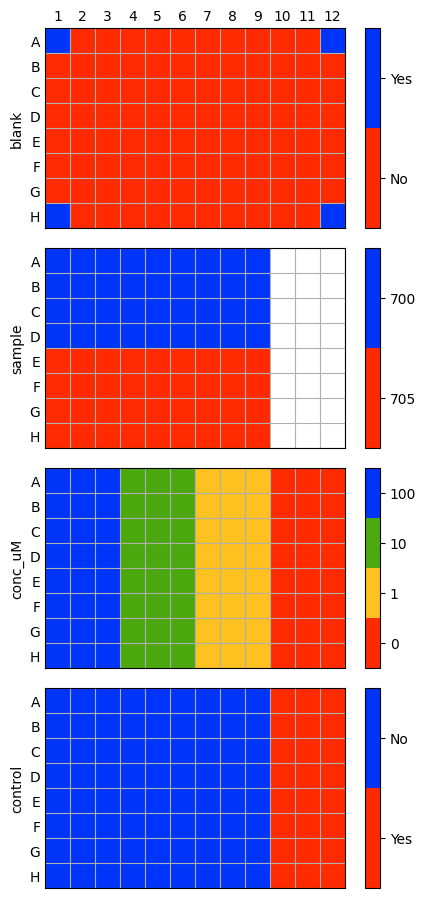

In [89]:
wellmap_path_list = []

for file in os.listdir(part_to_folder):
    if file.endswith(".toml"):
        wellmap_path_list.append(os.path.join(part_to_folder, file))
        # wellmap_path_list.append(file)

print(wellmap_path_list[0])

wellmap_df = wellmap.load(wellmap_path_list[0]) 

wellmap_list = []

for file in wellmap_path_list:
    wellmap_i = wellmap.load(file)
    wellmap_list.append(wellmap_i)

wellmaps_df = pd.concat(wellmap_list, axis=0, ignore_index=True)

wellmap.show(file);

Generating labels for wells

In [90]:
# row_column_df = pd.DataFrame(columns=['row','col'])

row =  list(string.ascii_uppercase[0:8])
column = list(range(1,13))
plate = image_list_df['FileName_RGB'].to_list()

row_column_list = []


for p in plate:
    for c in column:
        for r in row:
            array_i = [r,c]
            row_column_list.append(array_i)

row_column_df = pd.DataFrame(row_column_list, columns = ['row', 'col']) 

print(row_column_df)

    row  col
0     A    1
1     B    1
2     C    1
3     D    1
4     E    1
..   ..  ...
379   D   12
380   E   12
381   F   12
382   G   12
383   H   12

[384 rows x 2 columns]


Add images names to data (thank you CellProfiler for convenience)

In [91]:
data_full_df =  pd.merge(data_raw_df, image_list_df, on='ImageNumber') #Data with image names (FileName_RGB)
data_indexed = pd.concat([row_column_df, data_full_df], axis=1, join='inner') #Data with image names (FileName_RGB) and cell indexes (row,col)

data_indexed['col']=data_indexed['col'].astype(str) #Otherwise everything will break

data_plate = pd.merge(data_indexed, wellmaps_df, on=['FileName_RGB','row','col']) #Data with image names (FileName_RGB), cell indexes and wellmap
data_plate[["conc_uM"]] = data_plate[["conc_uM"]].apply(pd.to_numeric)



Blank and control calculation for each plate

In [92]:
blank_control_array = []

for p in plate:
    blank_p = data_plate[(data_plate['blank'] == 'Yes') & (data_plate['FileName_RGB'] == p)].loc[:,'Intensity_MeanIntensity_OrigGreen'].mean()
    control_p = data_plate[(data_plate['control'] == 'Yes') & (data_plate['blank'] == 'No') & (data_plate['FileName_RGB'] == p)].loc[:,'Intensity_MeanIntensity_OrigGreen'].mean()
    bc_array_i = [blank_p,control_p,p]

    blank_control_array.append(bc_array_i)


blank_control_df = pd.DataFrame(blank_control_array, columns = ['blank_mean', 'control_mean','FileName_RGB']) 

print(blank_control_df)




   blank_mean  control_mean                                       FileName_RGB
0    0.008301      0.020079  2024-07-17 RD Belskaya 700 705 UV 3H (Multicha...
1    0.008647      0.025845  2024-07-17 RD Belskaya 700 705 dark 3H (Multic...
2    0.010687      0.032264  2024-07-17 Vero Belskaya 700 705 UV 3H (Multic...
3    0.009354      0.028280  2024-07-17 Vero Belskaya 700 705 dark 3H (Mult...


Blank exclusion and relative values calculating

In [97]:
data_plate_wo_blank_wells = data_plate[data_plate.blank == 'No'].copy() #dataframe without blank

data_plate_with_mean_blank_control = pd.merge(data_plate_wo_blank_wells, blank_control_df, on=['FileName_RGB'])

data_plate_with_mean_blank_control['Green_blanked'] = data_plate_with_mean_blank_control['Intensity_MeanIntensity_OrigGreen'] - data_plate_with_mean_blank_control['blank_mean']
data_plate_with_mean_blank_control['Green_relative'] = data_plate_with_mean_blank_control['Green_blanked']/data_plate_with_mean_blank_control['control_mean']*100

Sample selection

In [110]:
data_selected = data_plate_with_mean_blank_control[(data_plate_with_mean_blank_control['cells'] == 'Vero') & 
                                                   (data_plate_with_mean_blank_control['sample'] == '705')]

# print(data_selected)

Plotting


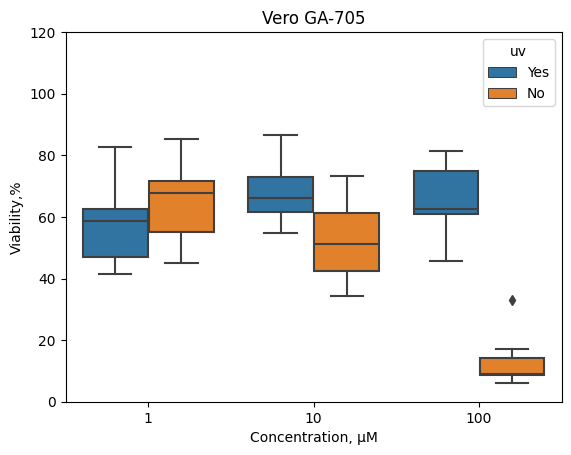

In [111]:
# ax = sns.relplot(data=data_plate_with_mean_blank_control, x="conc_uM", y="Green_relative", kind="line", hue = 'uv', ci=None)

ax = sns.boxplot(data=data_selected, x="conc_uM", y="Green_relative", hue='uv')



# ax.set(xlabel=None, ylabel='Viable cell, % of control')

ax.set(xlabel='Concentration, μM', ylabel='Viability,%')
# ax.set(xscale="symlog")

ax.set(ylim=(0, 120))

plt.title("Vero GA-705")

plt.show()



C:\Users\Modern\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\seaborn\categorical.py:1296: UserWarning: 8.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\Modern\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\seaborn\categorical.py:1296: UserWarning: 16.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\Modern\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\seaborn\categorical.py:1296: UserWarning: 12.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


[(-1.0, 110.0)]

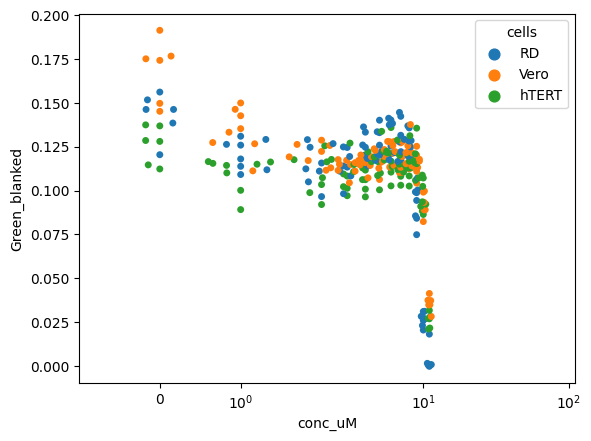

In [178]:
ax = sns.swarmplot(data=data_plate_with_mean_blank_control, x="conc_uM", y="Green_blanked", hue = 'cells')
ax.set(xscale="symlog")
ax.set(xlim=(-1, 110))
